In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Add, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, InputLayer, GlobalAveragePooling2D ,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.rcParams['font.size'] = 14

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!cp -r "/content/drive/MyDrive/blood_cells" "/content/"


In [4]:
img_size = 224
batch_size = 16


train_datagen = ImageDataGenerator(rescale = 1/255.,brightness_range=[0.5,1.5], zoom_range=0.2, 
                                   width_shift_range =0.15, height_shift_range =0.15, horizontal_flip=True )
val_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


train_generator = train_datagen.flow_from_directory('/content/blood_cells/dataset2-master/dataset2-master/images/TRAIN',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=True,
                                                   class_mode='sparse')

val_generator = val_datagen.flow_from_directory('/content/blood_cells/dataset2-master/dataset2-master/images/TEST_SIMPLE',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='sparse')

test_generator = test_datagen.flow_from_directory('/content/blood_cells/dataset2-master/dataset2-master/images/TEST',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode = "sparse")

Found 9967 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2489 images belonging to 4 classes.


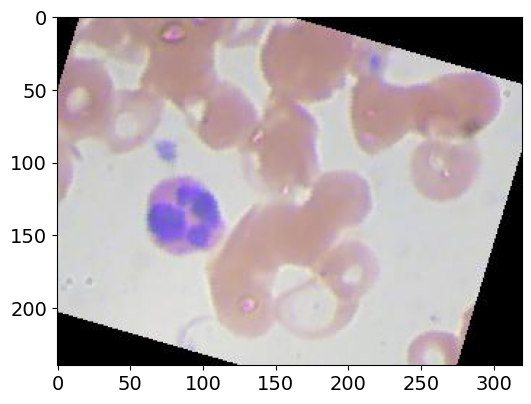

In [5]:
from glob import glob 
path_train = "/content/blood_cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL"
img = glob(path_train+"/*.jpeg")
# print(img)
img = np.asarray(plt.imread(img[17]))
plt.figure(figsize = (6, 6))
plt.imshow(img)
plt.show()

In [6]:
def residual_block(x, kernel_size, filters, s=2):
    f1,f2,f3 = filters
    x_shortcut = x
    
    # Shortcut Path
    x_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(s,s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    # Main Path
    # First Component
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Component
    x = Conv2D(f2, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third Component
    x = Conv2D(f3, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [7]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(64, kernel_size=(7,7), strides=(2,2))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)

x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])

x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])

# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output_layer = Dense(4, activation='softmax')(x)

resnet50 = Model(inputs=input_layer,outputs=output_layer)

In [8]:
#resnet50.summary()

In [9]:
#tf.keras.utils.plot_model(resnet50,to_file='resnet50.png')

In [10]:
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
history = resnet50.fit(train_generator,
                        epochs=50,
                        validation_data=val_generator,
                        callbacks=[checkpoint,earlystopping])



Epoch 1/50
623/623 [==============================] - ETA: 0s - loss: 1.6987 - accuracy: 0.2488
Epoch 1: val_loss improved from inf to 1.51660, saving model to /tmp/checkpoint


623/623 [==============================] - 233s 299ms/step - loss: 1.6987 - accuracy: 0.2488 - val_loss: 1.5166 - val_accuracy: 0.2113
Epoch 2/50
623/623 [==============================] - ETA: 0s - loss: 1.5502 - accuracy: 0.2463
Epoch 2: val_loss did not improve from 1.51660
623/623 [==============================] - 159s 255ms/step - loss: 1.5502 - accuracy: 0.2463 - val_loss: 1.7327 - val_accuracy: 0.0423
Epoch 3/50
623/623 [==============================] - ETA: 0s - loss: 1.4572 - accuracy: 0.2514
Epoch 3: val_loss improved from 1.51660 to 1.39595, saving model to /tmp/checkpoint


623/623 [==============================] - 180s 288ms/step - loss: 1.4572 - accuracy: 0.2514 - val_loss: 1.3960 - val_accuracy: 0.1831
Epoch 4/50
623/623 [==============================] - ETA: 0s - loss: 1.4161 - accuracy: 0.2446
Epoch 4: val_loss improved from 1.39595 to 1.39491, saving model to /tmp/checkpoint


623/623 [==============================] - 191s 307ms/step - loss: 1.4161 - accuracy: 0.2446 - val_loss: 1.3949 - val_accuracy: 0.1972
Epoch 5/50
623/623 [==============================] - ETA: 0s - loss: 1.4044 - accuracy: 0.2572
Epoch 5: val_loss improved from 1.39491 to 1.33226, saving model to /tmp/checkpoint


623/623 [==============================] - 186s 298ms/step - loss: 1.4044 - accuracy: 0.2572 - val_loss: 1.3323 - val_accuracy: 0.3662
Epoch 6/50
623/623 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.2572
Epoch 6: val_loss did not improve from 1.33226
623/623 [==============================] - 163s 261ms/step - loss: 1.4010 - accuracy: 0.2572 - val_loss: 1.3634 - val_accuracy: 0.3099
Epoch 7/50
623/623 [==============================] - ETA: 0s - loss: 1.3863 - accuracy: 0.2854
Epoch 7: val_loss did not improve from 1.33226
623/623 [==============================] - 158s 253ms/step - loss: 1.3863 - accuracy: 0.2854 - val_loss: 1.7046 - val_accuracy: 0.0563
Epoch 8/50
623/623 [==============================] - ETA: 0s - loss: 1.2475 - accuracy: 0.4090
Epoch 8: val_loss did not improve from 1.33226
623/623 [==============================] - 159s 255ms/step - loss: 1.2475 - accuracy: 0.4090 - val_loss: 1.4990 - val_accuracy: 0.2113
Epoch 9/50
623/623 [===========

623/623 [==============================] - 178s 285ms/step - loss: 1.0370 - accuracy: 0.5240 - val_loss: 1.0621 - val_accuracy: 0.3803
Epoch 10/50
623/623 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.6531
Epoch 10: val_loss improved from 1.06207 to 0.62862, saving model to /tmp/checkpoint


623/623 [==============================] - 172s 277ms/step - loss: 0.7866 - accuracy: 0.6531 - val_loss: 0.6286 - val_accuracy: 0.7465
Epoch 11/50
623/623 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.7250
Epoch 11: val_loss did not improve from 0.62862
623/623 [==============================] - 153s 246ms/step - loss: 0.6497 - accuracy: 0.7250 - val_loss: 1.6204 - val_accuracy: 0.2676
Epoch 12/50
623/623 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.7840
Epoch 12: val_loss improved from 0.62862 to 0.41144, saving model to /tmp/checkpoint


623/623 [==============================] - 170s 273ms/step - loss: 0.5364 - accuracy: 0.7840 - val_loss: 0.4114 - val_accuracy: 0.8592
Epoch 13/50
623/623 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.8147
Epoch 13: val_loss did not improve from 0.41144
623/623 [==============================] - 156s 251ms/step - loss: 0.4673 - accuracy: 0.8147 - val_loss: 0.8796 - val_accuracy: 0.5070
Epoch 14/50
623/623 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8396
Epoch 14: val_loss did not improve from 0.41144
623/623 [==============================] - 154s 247ms/step - loss: 0.4180 - accuracy: 0.8396 - val_loss: 0.7602 - val_accuracy: 0.8028
Epoch 15/50
623/623 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8454
Epoch 15: val_loss did not improve from 0.41144
623/623 [==============================] - 153s 246ms/step - loss: 0.3861 - accuracy: 0.8454 - val_loss: 1.2777 - val_accuracy: 0.5493
Epoch 16/50
623/623 [====

623/623 [==============================] - 179s 287ms/step - loss: 0.3547 - accuracy: 0.8572 - val_loss: 0.3521 - val_accuracy: 0.8592
Epoch 17/50
623/623 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8708
Epoch 17: val_loss did not improve from 0.35206
623/623 [==============================] - 154s 247ms/step - loss: 0.3306 - accuracy: 0.8708 - val_loss: 0.4152 - val_accuracy: 0.8169
Epoch 18/50
623/623 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8823
Epoch 18: val_loss improved from 0.35206 to 0.26385, saving model to /tmp/checkpoint


623/623 [==============================] - 170s 273ms/step - loss: 0.3092 - accuracy: 0.8823 - val_loss: 0.2638 - val_accuracy: 0.9577
Epoch 19/50
623/623 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8878
Epoch 19: val_loss did not improve from 0.26385
623/623 [==============================] - 154s 247ms/step - loss: 0.2907 - accuracy: 0.8878 - val_loss: 0.3336 - val_accuracy: 0.9155
Epoch 20/50
623/623 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.8953
Epoch 20: val_loss did not improve from 0.26385
623/623 [==============================] - 156s 251ms/step - loss: 0.2732 - accuracy: 0.8953 - val_loss: 0.3239 - val_accuracy: 0.9437
Epoch 21/50
623/623 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9023
Epoch 21: val_loss did not improve from 0.26385
623/623 [==============================] - 159s 255ms/step - loss: 0.2525 - accuracy: 0.9023 - val_loss: 0.5012 - val_accuracy: 0.8169
Epoch 22/50
623/623 [====

623/623 [==============================] - 176s 283ms/step - loss: 0.2270 - accuracy: 0.9118 - val_loss: 0.2409 - val_accuracy: 0.9155
Epoch 24/50
623/623 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9217
Epoch 24: val_loss did not improve from 0.24094
623/623 [==============================] - 158s 254ms/step - loss: 0.2065 - accuracy: 0.9217 - val_loss: 0.8283 - val_accuracy: 0.6197
Epoch 25/50
623/623 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9173
Epoch 25: val_loss improved from 0.24094 to 0.21260, saving model to /tmp/checkpoint


623/623 [==============================] - 177s 284ms/step - loss: 0.2135 - accuracy: 0.9173 - val_loss: 0.2126 - val_accuracy: 0.9014
Epoch 26/50
623/623 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9225
Epoch 26: val_loss did not improve from 0.21260
623/623 [==============================] - 158s 253ms/step - loss: 0.2019 - accuracy: 0.9225 - val_loss: 3.2871 - val_accuracy: 0.6901
Epoch 27/50
623/623 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.9347
Epoch 27: val_loss did not improve from 0.21260
623/623 [==============================] - 158s 253ms/step - loss: 0.1722 - accuracy: 0.9347 - val_loss: 0.5100 - val_accuracy: 0.8310
Epoch 28/50
623/623 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9285
Epoch 28: val_loss did not improve from 0.21260
623/623 [==============================] - 157s 252ms/step - loss: 0.1942 - accuracy: 0.9285 - val_loss: 0.6355 - val_accuracy: 0.8310
Epoch 29/50
623/623 [====

In [13]:
resnet50.save('content/model')


In [14]:
#from tensorflow.keras.models import load_model

# Load the model
#resnet50 = load_model('content/model')

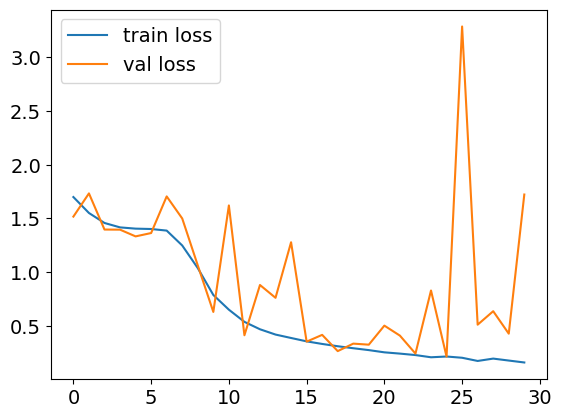

In [15]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

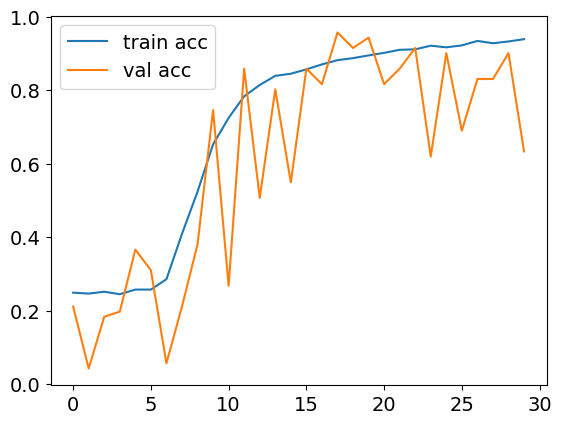

In [16]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [17]:
y_pred = resnet50.predict(test_generator).round()
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

156/156 [==============================] - 9s 52ms/step


In [18]:
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test,y_pred,target_names = class_labels))

              precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.83      0.88       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       0.99      0.75      0.85       622
  NEUTROPHIL       0.70      0.93      0.80       624

    accuracy                           0.88      2489
   macro avg       0.90      0.88      0.88      2489
weighted avg       0.90      0.88      0.88      2489



In [19]:
print(accuracy_score(y_test, y_pred))

0.8786661309762958


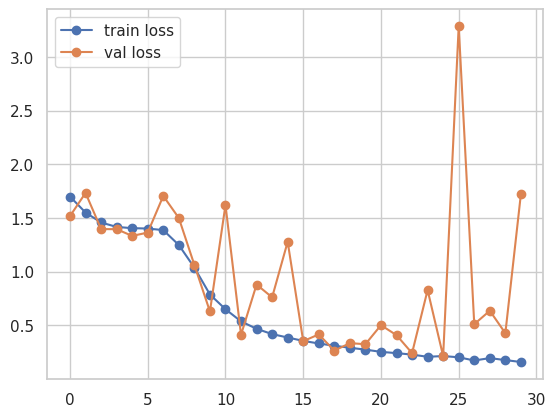

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid') 

plt.plot(history.history['loss'], '-o', label='train loss') 
plt.plot(history.history['val_loss'], '-o', label='val loss')
plt.legend()
plt.show()


In [21]:
!cp -r "/content/content/model" "/content/drive/MyDrive/blood_cells/"

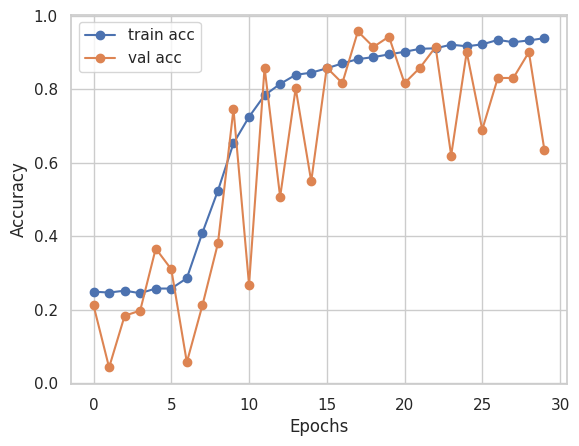

In [27]:
plt.plot(history.history['accuracy'], '-o',label='train acc')
plt.plot(history.history['val_accuracy'],'-o', label='val acc')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.show()

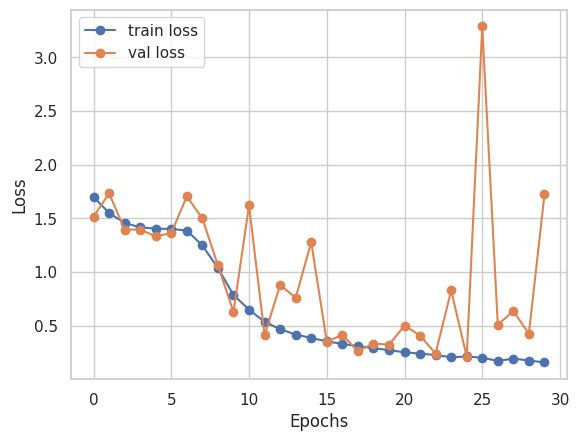

In [22]:
plt.plot(history.history['loss'], '-o', label='train loss')
plt.plot(history.history['val_loss'], '-o', label='val loss')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.show()
